# Simple neural network


In this notebook, we are going to create and train a simple neural network on the digits dataset using pytorch.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

First, we need to load the data and make them into pytorch tensors.

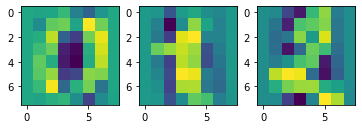

In [ ]:
X, y = load_digits(return_X_y=True)

# Normalize

X -= X.mean(axis=0)
X /= np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

f, axes = plt.subplots(1, 3)
for i, axe in enumerate(axes):
    axe.imshow(X[i].reshape(8, 8))

x = torch.tensor(X_train).float()
y = torch.tensor(y_train).long()
n, p = x.shape
x_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()

# Define the network

We will work with a simple network with two layers (one hidden layer).

The input $x$ is transformed into the output $z$ by the following operations:

$$y = \tanh(W_1x + b_1)$$
$$z = W_2y + b_2$$

**Exercise 1**: Define a function `net(x, W1, b1, W2, b2)` that implements this transform. Remember that `x` is a matrix of size $n\times p$

In [ ]:
def net(x, W1, b1, W2, b2):
  # x.shape == (n, p)
  # W1.shape == (p, d)
  # b1 == (d, )
  y = torch.tanh(x @ W1 + b1[None, :])
  # y.shape = (n, d)
  # W2.shape = (d, N)
  z = y @ W2 + b2[None, :]
  # z = torch.mm(y, W2) + b2
  # z.shape == (n, N)
  return z

Next, let us specify the parameters of the network, `W1, b1, W2, b2`. You can chose the size of the hidden layer, but the input and output sizes are determined by the problem.

**Exercise 2**: Define a set of parameters `W1, b1, W2, b2`, where you chose the size of the hidden layer. Make sure that all these parameters have their `requires_grad` flag set to true, so that we can compute the gradient with respect to them.

In order to check that eveything works, compute `net(x, W1, b1, W2, b2)`.

In [ ]:
hidden_size = 20
input_size = 64
output_size = 10

W1 = torch.randn(input_size, hidden_size) / np.sqrt(input_size)
W1.requires_grad = True
b1 = torch.zeros(hidden_size)
b1.requires_grad = True
W2 = torch.randn(hidden_size, output_size) / np.sqrt(hidden_size)
W2.requires_grad = True
b2 = torch.zeros(output_size)
b2.requires_grad = True
output = net(x, W1, b1, W2, b2)

In [ ]:
output.shape

torch.Size([1347, 10])

Next, we will define a cost function. We will use the classical cross entropy loss. It is imported from pytorch in the next cell.

In [ ]:
from torch.nn.functional import cross_entropy

**Exercise 3**: Compute the current loss of the network, and then back-propagate to compute the gradient with respect to the parameters. Check the gradient with respect to W1.

In [ ]:
loss = cross_entropy(input=output, target=y, reduction='mean')

In [ ]:
loss.shape

torch.Size([])

We are almost ready to train our network!

But first, we will need to compute the accuracy of the network, on the train and test set.

**Exercise 4**: Define a function `accuracy(X, y, W1, b1, W2, b2)` that computes the accuracy of the network on the dataset `x`with true labels `y`. Remember that the predicted class at the output of the network is computed as the argmaximum of the output. Compute the current accuracy of the network on the train set. Is it normal ?

In [ ]:
  f = net(x, W1, b1, W2, b2)
  pred = torch.argmax(f, axis=1)

In [ ]:
y.shape

torch.Size([1347])

In [ ]:
match = pred == y

In [ ]:
match.shape

torch.Size([1347])

In [ ]:
match.float().mean()

tensor(0.1062)

In [ ]:
def accuracy(x, y, W1, b1, W2, b2):
  f = net(x, W1, b1, W2, b2)
  pred = torch.argmax(f, axis=1)
  match = pred == y
  accuracy = match.float().mean()
  return accuracy

accuracy(x, y, W1, b1, W2, b2)

tensor(0.1062)

# Training the network

We are now ready to train the network, using back-propagation and stochastic gradient descent.
First, we define the number of iterations of the algorithm, the step size, and the batch size. We also reinitialize the weights. Finally, we will store the train and test accuracy during the training.

In [ ]:
n_iter = 1000
step_size = 0.1
batch_size = 64

test_list = []
train_list = []

**Exercise 5**: Complete the following training list, so that each parameter is updated at each iteration.

Remember that at each iteration, you should:
* compute the output of the network with respect to the batch
* Compute the loss, and backpropagate
* Update each parameter with gradient descent
* Refresh the gradient of each parameter. To do so, you can do:

```
W1 = W1.detach()
W1.requires_grad=True
```

In [ ]:
W1.requires_grad

True

In [ ]:
loss.

tensor(2.4075, grad_fn=<NllLossBackward>)

In [ ]:
W1.data = W1.data - step_size * W1.grad
W1.grad.zero_()

In [ ]:
W1.requires_grad

False

In [ ]:
for i in range(n_iter):
    # Selection of the batch here
    batch_idx = torch.randperm(n)[:batch_size]
    x_batch = x[batch_idx]
    y_batch = y[batch_idx]
    # YOUR CODE HERE: Compute the output of the network, the loss, and backpropagate
    f_batch = net(x_batch, W1, b1, W2, b2)
    loss = cross_entropy(f_batch, y_batch)
    loss.backward()
    
    with torch.no_grad():
      W1.data = W1.data - step_size * W1.grad
      W1.grad.zero_()

      W2.data = W2.data - step_size * W2.grad
      W2.grad.zero_()
      
      b1.data = b1.data - step_size * b1.grad
      b1.grad.zero_()

      b2.data = b2.data - step_size * b2.grad
      b2.grad.zero_()
        
    # Utility to print the current state of training
    if i % 10 == 0:
        with torch.no_grad():
            train_acc = accuracy(x, y, W1, b1, W2, b2)
            test_acc = accuracy(x_test, y_test, W1, b1, W2, b2)
        test_list.append(test_acc)
        train_list.append(train_acc)
        print('Iteration {} Train loss: {:1.3f} Train acc: {:1.3f} Test acc {:1.3f}'.format(i, loss.item(), train_acc, test_acc))

Iteration 0 Train loss: 2.395 Train acc: 0.146 Test acc 0.133
Iteration 10 Train loss: 1.567 Train acc: 0.670 Test acc 0.660
Iteration 20 Train loss: 1.109 Train acc: 0.836 Test acc 0.833
Iteration 30 Train loss: 0.918 Train acc: 0.880 Test acc 0.891
Iteration 40 Train loss: 0.691 Train acc: 0.899 Test acc 0.909
Iteration 50 Train loss: 0.618 Train acc: 0.909 Test acc 0.911
Iteration 60 Train loss: 0.502 Train acc: 0.918 Test acc 0.920
Iteration 70 Train loss: 0.580 Train acc: 0.927 Test acc 0.931
Iteration 80 Train loss: 0.455 Train acc: 0.931 Test acc 0.933
Iteration 90 Train loss: 0.433 Train acc: 0.931 Test acc 0.940
Iteration 100 Train loss: 0.351 Train acc: 0.936 Test acc 0.942
Iteration 110 Train loss: 0.334 Train acc: 0.941 Test acc 0.938
Iteration 120 Train loss: 0.457 Train acc: 0.948 Test acc 0.944
Iteration 130 Train loss: 0.265 Train acc: 0.950 Test acc 0.944
Iteration 140 Train loss: 0.188 Train acc: 0.950 Test acc 0.940
Iteration 150 Train loss: 0.253 Train acc: 0.952 Te

**Exercise 6**: Display the learning curves. You can then play with the network and training parameters:
what happens when you change the learning rate, the number of hidden sizes, etc?

In [ ]:
test_list

[tensor(0.1333),
 tensor(0.6600),
 tensor(0.8333),
 tensor(0.8911),
 tensor(0.9089),
 tensor(0.9111),
 tensor(0.9200),
 tensor(0.9311),
 tensor(0.9333),
 tensor(0.9400),
 tensor(0.9422),
 tensor(0.9378),
 tensor(0.9444),
 tensor(0.9444),
 tensor(0.9400),
 tensor(0.9533),
 tensor(0.9467),
 tensor(0.9533),
 tensor(0.9556),
 tensor(0.9556),
 tensor(0.9578),
 tensor(0.9511),
 tensor(0.9556),
 tensor(0.9556),
 tensor(0.9578),
 tensor(0.9578),
 tensor(0.9578),
 tensor(0.9578),
 tensor(0.9556),
 tensor(0.9578),
 tensor(0.9556),
 tensor(0.9556),
 tensor(0.9578),
 tensor(0.9578),
 tensor(0.9578),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9622),
 tensor(0.9622),
 tensor(0.9578),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9600),
 tensor(0.9622),
 tensor(0.9600),
 tensor(0.9622),
 tensor(0.9600),
 tensor(0.9644),
 tensor(0.9644),
 tensor(0.9622),
 tensor(0.9644),
 tensor(0.9644),
 tensor(0.9622

In [ ]:
train_list

[tensor(0.1455),
 tensor(0.6696),
 tensor(0.8359),
 tensor(0.8805),
 tensor(0.8990),
 tensor(0.9087),
 tensor(0.9183),
 tensor(0.9265),
 tensor(0.9310),
 tensor(0.9310),
 tensor(0.9362),
 tensor(0.9406),
 tensor(0.9480),
 tensor(0.9495),
 tensor(0.9503),
 tensor(0.9517),
 tensor(0.9517),
 tensor(0.9569),
 tensor(0.9614),
 tensor(0.9629),
 tensor(0.9644),
 tensor(0.9659),
 tensor(0.9651),
 tensor(0.9666),
 tensor(0.9710),
 tensor(0.9710),
 tensor(0.9740),
 tensor(0.9733),
 tensor(0.9748),
 tensor(0.9748),
 tensor(0.9748),
 tensor(0.9755),
 tensor(0.9770),
 tensor(0.9777),
 tensor(0.9777),
 tensor(0.9785),
 tensor(0.9792),
 tensor(0.9807),
 tensor(0.9822),
 tensor(0.9822),
 tensor(0.9814),
 tensor(0.9807),
 tensor(0.9807),
 tensor(0.9807),
 tensor(0.9822),
 tensor(0.9822),
 tensor(0.9829),
 tensor(0.9829),
 tensor(0.9837),
 tensor(0.9844),
 tensor(0.9852),
 tensor(0.9844),
 tensor(0.9859),
 tensor(0.9866),
 tensor(0.9859),
 tensor(0.9859),
 tensor(0.9859),
 tensor(0.9859),
 tensor(0.9859

In [ ]:
import matplotlib.pyplot as plt

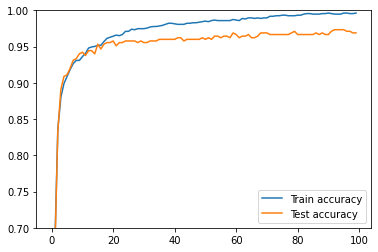

In [ ]:
plt.plot(train_list, label='Train accuracy')
plt.plot(test_list, label='Test accuracy')
plt.ylim([0.7, 1])
plt.legend()